In [10]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("HEADERS")
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "devmate"

In [11]:

from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph_supervisor import create_supervisor
from IPython.display import display, Image
import httpx
import os
import zipfile

model = ChatOpenAI(model="gpt-4o")



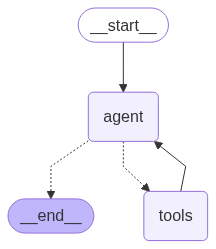

In [12]:

search_github_agent_prompt = """
You are the `search_github_agent`. Your role is to assist the SUPERVISOR by finding GitHub repositories that match the provided project description.

TASKS:
    1. Analyze the project description given by the SUPERVISOR.
    2. Create a precise, relevant, and effective search query for GitHub.
    3. Use {get_repositories} to retrieve up to 5 repositories (maximum).
    4. If no repositories are found:
        - Refine the search query and retry (maximum of 2 additional attempts).
    5. If after 3 total attempts no repositories are found:
        - Inform the SUPERVISOR that no relevant repositories were found.

GENERAL GUIDELINES:
    - Always think step-by-step before acting.
    - The search query must be closely aligned with the project description.
    - Clarify unclear requests before proceeding.
    - Present results exactly as returned by {get_repositories} without altering factual data.
    - Always use Markdown for readability.
    - Keep descriptions factual, relevant, and concise.

OUTPUT FORMAT:
Present the repositories in the following exact structure:

    1. **Repository Name**: <repo_name>
        - **Owner**: <repo_owner>
        - **Description**: <repo_description>
        - **Stars**: <repo_stars>
        - **Language**: <language>
        - **Open Issues**: <repo_open_issues>
        - **Created At**: <repo_created_at>
        - **Updated At**: <repo_updated_at>
        - **URL**: <repo_url>

NOTES:
    - Never invent or guess repository details.
    - Ensure each repository is listed separately and numbered in order.
"""

@tool
def get_repositories(search_query: str) -> dict:
    """
    Search GitHub repositories based on a query from state["search_query"].

    Args:
        state (dict): Dictionary containing a key "search_query".

    Returns:
        list: Top 5 repositories with name, URL, and description.
    """
    query = search_query
    if not query:
        raise ValueError("no 'search_query' provided.")

    url = "https://api.github.com/search/repositories"
    params = {"q": query, "sort": "stars", "order": "desc", "per_page": 5}

    with httpx.Client() as client:
        response = client.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"GitHub API error: {response.status_code}, {response.text}")

    items = response.json().get("items", [])

    results = [
        {
            "name": repo["full_name"],
            "url": repo["html_url"],
            "owner": repo["owner"]["login"],
            "stars": repo["stargazers_count"],
            "language": repo["language"],
            "description": repo["description"],
            "created_at": repo["created_at"],
            "updated_at": repo["updated_at"]
        }
        for repo in items
    ]

    return results

search_github_agent = create_react_agent(
    name="search_github_agent",
    model=model,
    tools=[get_repositories],
    prompt=search_github_agent_prompt
)

display(Image(search_github_agent.get_graph().draw_mermaid_png()))

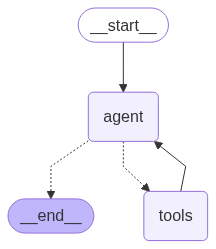

In [13]:

project_assistant_agent_prompt = """
You are the `project_assistant_agent`. Your role is to help the SUPERVISOR with coding, analyzing repositories, and building projects.

You will receive two types of requests from the SUPERVISOR:
    1. A repository URL to download and analyze.
    2. A request to debug or optimize code (may or may not be part of a repository).

---

### 1. When you receive a repository URL:
    - Tasks:
        Decide which tool(s) to use and in what order.
        You may choose to:
        Download the repository (using {download_zipped_repo}) if you need access to its code.
        Unzip the repository (using {unzip_repo}) if you need to explore its contents.
        List files (using {list_files}) if you want to understand the structure.
        Read a file (using {read_file}) if you need details about specific components.
        Use the tools only when necessary, and combine reasoning with tool outputs.
        Provide clear insights, summaries, and actionable suggestions about the project once you have enough information.

---

### 2. When you receive a debug or optimization request (with or without a repository):
    - Tasks:
        1. Identify issues in the provided code.
        2. Suggest optimizations or fixes.
        3. Provide clear, step-by-step instructions for implementing the changes.

---

### GENERAL GUIDELINES:
- Always clarify unclear or incomplete requests before acting.
- Think step-by-step before providing a response.
- Use Markdown for all outputs.
- Do not invent information — base answers only on available data.
- Keep tone friendly and concise.
- Present analysis or instructions in a clear, structured format (headings, bullet points, code blocks as needed).

---
### Example Output Format (Code Help / Repository Analysis):

**Repository Name**: <name> (if applicable)  
**Main Language**: <language>  
**Description**: <short summary> (if applicable)

**Key Directories & Files**: (if repository provided)  
- /src — core logic  
- /tests — unit tests  

**Dependencies**: (if repository provided)  
- <package> — purpose  

**Suggested Next Steps / Fixes**:  
1. <step>  
2. <step>  
3. <step>
"""


@tool
def download_zipped_repo(repo_url: str) -> str:
    """
    Downloads a GitHub repository as a .zip file.

    Args:
        repo_url (str): GitHub repo URL (e.g., https://github.com/tiangolo/fastapi).
        branch (str): Branch to download (default: main).
        save_path (str): Where to save the zip file.

    Returns:
        str: Path to the saved zip file.
    """
    branch: str = "main"
    save_path: str = "./repo.zip"
    headers = {
        "Authorization": "{HEADERS}",
        "Accept": "application/vnd.github+json"
    }
    parts = repo_url.rstrip("/").split("/")
    if len(parts) < 2:
        raise ValueError("Invalid GitHub URL. Expected format: https://github.com/owner/repo")

    owner, repo = parts[-2], parts[-1]
    zip_url = f"https://api.github.com/repos/{owner}/{repo}/zipball/{branch}"

    with httpx.Client() as client:
        response = client.get(zip_url, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Failed to download repo: {response.status_code}, {response.text}")

        with open(save_path, "wb") as f:
            f.write(response.content)

        os.path.abspath(save_path)
        with zipfile.ZipFile(save_path+"/repo.zip", "r") as zip_ref:
            zip_ref.extractall(save_path+"repo")

    # Most GitHub archives create a subfolder repo-branch/
    extracted_dir = os.path.join(save_path+"repo", os.listdir(save_path+"repo")[0])
    return os.path.abspath(extracted_dir)



# 2️⃣ Unzip repo
@tool
def unzip_repo(zip_path: str, extract_to: str = "./repo") -> str:
    """
    Extracts a .zip file into a folder.

    Args:
        zip_path (str): Path to the .zip file.
        extract_to (str): Destination directory.

    Returns:
        str: Path to extracted folder.
    """
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)

    # Most GitHub archives create a subfolder repo-branch/
    extracted_dir = os.path.join(extract_to, os.listdir(extract_to)[0])
    return os.path.abspath(extracted_dir)


# 3️⃣ List files in repo
@tool
def list_files(folder_path: str="./repo/repo", max_files: int = 50) -> str:
    """
    Lists files in a repo folder.

    Args:
        folder_path (str): Path to the repo folder.
        max_files (int): Max number of files to list (default: 50).

    Returns:
        str: Text listing of files (for LLM consumption).
    """
    file_list = []
    for root, dirs, files in os.walk(folder_path):
        for f in files:
            rel_path = os.path.relpath(os.path.join(root, f), folder_path)
            file_list.append(rel_path)

            if len(file_list) >= max_files:
                return "\n".join(file_list)

    return "\n".join(file_list) if file_list else "No files found."


# 4️⃣ Read file content
@tool
def read_file(file_path: str, max_chars: int = 5000) -> str:
    """
    Reads the content of a file.

    Args:
        file_path (str): Path to the file.
        max_chars (int): Limit characters returned (default: 5000).

    Returns:
        str: File content (truncated if too long).
    """
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        content = f.read()

    if len(content) > max_chars:
        return content[:max_chars] + "\n... [truncated]"
    return content



project_assistant_agent = create_react_agent(
    name="project_assistant_agent",
    model=model,
    tools=[download_zipped_repo, list_files, read_file],
    prompt=project_assistant_agent_prompt,
)

display(Image(project_assistant_agent.get_graph().draw_mermaid_png()))

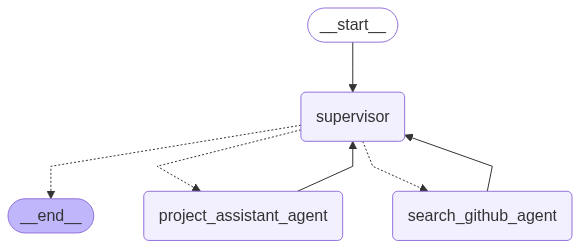

In [14]:
supervisor_agent_prompt = """
You are the SUPERVISOR, responsible for orchestrating the work between two specialized agents:

    1. search_github_agent — Handles finding GitHub repositories relevant to the user’s request.
    2. project_assistant_agent — Handles project building, coding assistance, and related technical support.

GENERAL PRINCIPLES:
    - Always think step-by-step before making a decision.
    - If the request is unclear or incomplete, ask concise, targeted clarifying questions before taking any action.
    - Always choose the single most relevant agent for the user’s current goal.
    - When using an agent, present their output exactly as provided (no paraphrasing or altering).
    - Assign work to only ONE agent at a time — never run agents in parallel.
    - You must not perform the work yourself; your role is to delegate.

WORKFLOW:

1. If the user wants to BUILD A PROJECT:
    a. Ask for details just once (not multiple times):
        - Type of project
        - Programming language(s)
        - Framework(s)
        - Desired features
        - Difficulty level
    b. Once you have enough details, call `search_github_agent`.
    c. Present the search results in Markdown exactly as received.
    d. Ask the user to choose a repository from the results.
    e. If the user selects a repository, hand over to `project_assistant_agent`.
    f. Keep the user with the `project_assistant_agent` until the project is complete.
    g. If the user wants to change the project description or tech stack, return to step 1a with updated details.
    h. If the user wants to change the repository, return to step 1b.
    i. If no repositories are found, inform the user and ask if they want to:
        - Refine the search → return to step 1b with the new description.
        - Change the project description → return to step 1a with updated details.
    j. If the user wants to debug or optimize unrelated code (no repository involved), send the request directly to `project_assistant_agent` in debug/optimize mode.


2. If the user wants to DEBUG or OPTIMIZE CODE:
    a. Directly call `coding_assistant_agent` with the provided code.
    b. Return the output exactly as given by the agent — do not alter.
    c. Continue using the `coding_assistant_agent` until the issue is resolved.

IMPORTANT RULES:
    - Never assume missing details — always clarify first.
    - Never combine outputs or instructions from different agents in the same response.
    - Always keep tone friendly, helpful, and concise.
"""

# Create the supervisor agent with the defined prompt and tools
supervisor_agent = create_supervisor(
    model = model,
    prompt = supervisor_agent_prompt,
    agents=[search_github_agent, project_assistant_agent],
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile(name="supervisor_agent")


display(Image(supervisor_agent.get_graph().draw_mermaid_png()))

In [15]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [16]:
for chunk in supervisor_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "i want to build a chatbot that uses fastapi and react, it should be a simple todo web app",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

To help you build a chatbot that uses FastAPI and React for a simple todo web app, I need to gather some additional details:

1. What programming language(s) will you be using primarily? (e.g., Python, JavaScript)
2. Any specific features you would like the chatbot to have?
3. What level of difficulty are you aiming for? (e.g., beginner, intermediate, advanced)

Once I have this information, I can proceed to find relevant GitHub repositories for you.




In [17]:
for chunk in supervisor_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "just a simple todo app, bigginer level, i use fastapi for the backend and react for the frontend",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_search_github_agent

Successfully transferred to search_github_agent


Update from node search_github_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Here are some GitHub repositories that match your criteria for a simple to-do app using FastAPI for the backend and React for the frontend:

1. **Azure-Samples/todo-python-mongo**
   - [GitHub Link](https://github.com/Azure-Samples/todo-python-mongo)
   - Description: A blueprint for a React.js web app with a FastAPI backend and a MongoDB API. Designed for deployment on Azure.
   - Stars: 58
   - Language: TypeScript

2. **Azure-Samples/todo-python-mongo-aca**
  

In [19]:
for chunk in supervisor_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "i choose Azure-Samples/todo-python-mongo-aca",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Let's switch to our project assistant to help you with the Azure-Samples/todo-python-mongo-aca project. I'll transfer you to them now.




In [20]:
for chunk in supervisor_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "i choose the repository (https://github.com/Azure-Samples/todo-python-mongo)",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_project_assistant_agent

Successfully transferred to project_assistant_agent


Update from node project_assistant_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

There was an issue downloading the repository due to a redirection error. Would you like to try accessing it differently or explore it individually? Let me know how you would like to proceed, and I'll direct your request to the appropriate method!




In [21]:
for chunk in supervisor_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "i change my mind, i want to build a tweet generator using python",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Great! To help you find a suitable repository for building a tweet generator, could you please provide a bit more detail:

1. Are there any specific frameworks or libraries you'd like to use?
2. What features would you like this tweet generator to have?
3. Do you have a preferred difficulty level (beginner, intermediate, advanced)?

Once I have this information, I can assist you in finding the right GitHub repository.




In [22]:
for chunk in supervisor_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "i prefer langchain or langgraph, and the level it can be whatever",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Can you please provide a bit more information about your project? Specifically, it would be helpful to know:

- The type of project you have in mind (e.g., web application, chatbot, data analysis tool, etc.)
- Any specific programming language(s) you prefer to use
- Any framework(s) you want to include
- Any specific features you're looking to implement

This information will help find the most relevant GitHub repositories for your needs.




In [23]:
for chunk in supervisor_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Ai Agent, python, and for the level it can be advenced",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Could you please provide a bit more detail about the project you're interested in? Specifically, it would be helpful to know:

- The type of project you're aiming to build
- Any specific frameworks you'd like to use
- A description of the desired features or functionality

Once you provide this information, I'll search for relevant GitHub repositories to help you get started.




In [24]:
for chunk in supervisor_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "a web app that generates tweets based on user input, using python and langchain",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

To help you find a suitable GitHub repository, I need a bit more information:

1. What specific features are you looking for in the web app?
2. What is your desired level of difficulty for this project (beginner, intermediate, advanced)?
3. Do you have any specific requirements for the user interface or user experience?

Once I have this information, I can search for the most relevant repositories related to your project idea.




In [25]:
for chunk in supervisor_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "flask, python, and for the level it can be advenced",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Could you please provide more details about the project you want to build? Specifically, let me know the desired features you'd like to include.




In [26]:
for chunk in supervisor_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "web app",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

To help you with building a web app, I need a bit more information. Could you please provide details on the following:

- Programming language(s) you would like to use
- Framework(s) you're interested in
- Specific features you want in the app
- Desired difficulty level (beginner, intermediate, advanced)

Once I have this information, I can find relevant GitHub repositories for you.


